# Regularization for a classifier of the cat/dog data from cifar10 dataset

In [55]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [56]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()

print([x.name for x in local_device_protos if x.device_type == 'GPU'])

['/device:GPU:0']


In [58]:
import matplotlib.pyplot as plt
import tensorflow
import keras

def plot_train_losses(hist):
    train_losses = hist.history['loss']
    test_losses = hist.history['val_loss']

    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.title("model loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_train_accuracy(hist):
    train_acc = hist.history['accuracy']
    test_acc = hist.history['val_accuracy']

    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.title("model accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_train_history(hist):
    plot_train_losses(hist)
    plot_train_accuracy(hist)

In [59]:

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

In [60]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, x_train.dtype, x_train.min(), x_train.max(), y_train.shape)
print(x_test.shape, x_test.dtype, x_test.min(), x_test.max(), y_test.shape)

(50000, 32, 32, 3) uint8 0 255 (50000, 1)
(10000, 32, 32, 3) uint8 0 255 (10000, 1)


In [90]:
def only_cat_dog_data(x, y):
    # cat label is 3 and gets mapped to 0
    cats = x[np.where(y == 3)[0]]
    cats_lab = [0 for i in range(cats.shape[0])]
    
    # dog label is 5 and gets mapped to 1
    dogs = x[np.where(y == 5)[0]]
    dogs_lab = [1 for i in range(dogs.shape[0])]


    x_new = np.vstack([cats, dogs])
    y_new = np.hstack([cats_lab, dogs_lab])

    return x_new, y_new

In [91]:
x_tr, y_tr = only_cat_dog_data(x_train, y_train)
print(x_tr.shape, y_tr.shape)
print(y_tr[:3], y_tr[5000:5003])

(10000, 32, 32, 3) (10000,)
[0 0 0] [1 1 1]


In [92]:
x_te, y_te = only_cat_dog_data(x_test, y_test)
print(x_te.shape, y_te.shape)
print(y_te[:3], y_te[1000:1003])

(2000, 32, 32, 3) (2000,)
[0 0 0] [1 1 1]


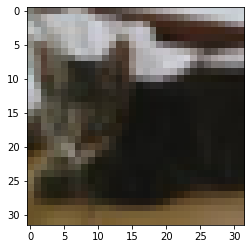

In [93]:
plt.imshow(x_tr[0])
plt.show()

In [94]:
# use only a small fraction of x_tr for training so overfitting can be made easier
np.random.seed(42)
size_small = int(0.3 * x_tr.shape[0])  ## 0.4 worked well!

sel_idx = np.random.choice(range(x_tr.shape[0]), size=size_small, replace=False)
#print(sel_idx[:5])

x_train_small = x_tr[sel_idx]
y_train_small = y_tr[sel_idx]

print(x_train_small.shape, y_train_small.shape)
print("class 1: {}/{}".format(np.sum(y_train_small), x_train_small.shape[0]))

(3000, 32, 32, 3) (3000,)
class 1: 1463/3000


## Setting up the input pipeline 

In [98]:
train_samples = x_train_small.shape[0]
test_samples = x_te.shape[0]

batch_size = 64
epochs = 30
test_samples

2000

In [99]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
)
train_generator = train_datagen.flow(x_train_small, y_train_small,
                                     batch_size=batch_size,
                                     shuffle=True)

In [100]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
)
test_generator = test_datagen.flow(x_te, y_te,
                                   batch_size=batch_size,
                                   shuffle=True)

## The baseline model

In [101]:
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D

### setting up the model architecture

In [102]:
input_shape = x_train_small.shape[1:]

def get_baseline_model_mlp():
    m_base = Sequential()
    m_base.add(Flatten(input_shape=input_shape))

    m_base.add(Dense(1024, activation="relu"))
    #m_base.add(Dense(1024, activation="relu"))
    m_base.add(Dense(512, activation="relu"))
    #m_base.add(Dense(512, activation="relu"))
    m_base.add(Dense(256, activation="relu"))
    m_base.add(Dense(128, activation="relu"))
    m_base.add(Dense(1, activation="sigmoid"))
    return m_base

def get_baseline_model_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [103]:
#m_base = get_baseline_model_mlp()
m_base = get_baseline_model_cnn()
print(m_base.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 6272)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               1605888   
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                      

### training the baseline model

In [104]:
from tensorflow.keras import optimizers

m_base.compile(optimizers.SGD(lr=0.01, momentum=0.9, decay=1.e-6, nesterov=True),
               #optimizers.Adadelta(),
               loss = "binary_crossentropy", 
               metrics=['accuracy'])


hist_base = m_base.fit_generator(train_generator,
                                 epochs=30,
                                 steps_per_epoch=train_samples // batch_size,
                                 validation_data=test_generator,
                                 validation_steps=test_samples // batch_size)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


46/46 [==============================] - 1s 9ms/step - loss: 0.6855 - accuracy: 0.5399 - val_loss: 0.6794 - val_accuracy: 0.5726
Epoch 2/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6673 - accuracy: 0.6032 - val_loss: 0.6723 - val_accuracy: 0.5731
Epoch 3/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6544 - accuracy: 0.6165 - val_loss: 0.6654 - val_accuracy: 0.5932
Epoch 4/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6461 - accuracy: 0.6322 - val_loss: 0.6721 - val_accuracy: 0.6023
Epoch 5/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6374 - accuracy: 0.6461 - val_loss: 0.6566 - val_accuracy: 0.6099
Epoch 6/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6270 - accuracy: 0.6482 - val_loss: 0.6509 - val_accuracy: 0.6255
Epoch 7/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6180 - accuracy: 0.6628 - val_loss: 0.6614 - val_accuracy: 0.6134
Epoch 8/30
46/46 [=============

In [106]:
len(hist_base.history['val_accuracy'])

30

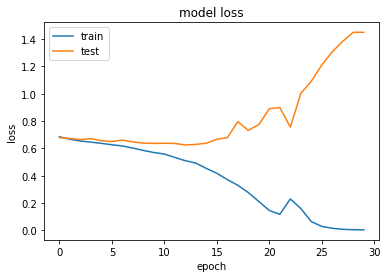

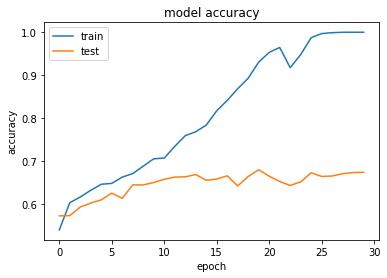

In [107]:
plot_train_history(hist_base)

## Using "early stopping"

In [108]:
# reset batch_size to original value
batch_size = 64

from keras.callbacks import EarlyStopping

m_base = get_baseline_model_cnn()

m_base.compile(optimizers.SGD(lr=0.01, momentum=0.9, decay=1.e-6, nesterov=True),
               #optimizers.Adadelta(),
               "binary_crossentropy", 
               metrics=['accuracy'])

hist_earlystop = m_base.fit_generator(train_generator,
                                      epochs=epochs,
                                      steps_per_epoch=train_samples // batch_size,
                                      validation_data=test_generator,
                                      validation_steps=test_samples // batch_size,
                                      callbacks=[
                                          EarlyStopping(monitor='val_loss', min_delta=0.1, patience=15, verbose=1)])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


46/46 [==============================] - 1s 9ms/step - loss: 0.6828 - accuracy: 0.5671 - val_loss: 0.6717 - val_accuracy: 0.5983
Epoch 2/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6617 - accuracy: 0.5967 - val_loss: 0.6651 - val_accuracy: 0.5892
Epoch 3/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6486 - accuracy: 0.6209 - val_loss: 0.6612 - val_accuracy: 0.6023
Epoch 4/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6380 - accuracy: 0.6396 - val_loss: 0.6808 - val_accuracy: 0.5716
Epoch 5/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6269 - accuracy: 0.6519 - val_loss: 0.6555 - val_accuracy: 0.6179
Epoch 6/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6120 - accuracy: 0.6713 - val_loss: 0.6497 - val_accuracy: 0.6280
Epoch 7/30
46/46 [==============================] - 0s 7ms/step - loss: 0.5965 - accuracy: 0.6887 - val_loss: 0.6384 - val_accuracy: 0.6411
Epoch 8/30
46/46 [=============

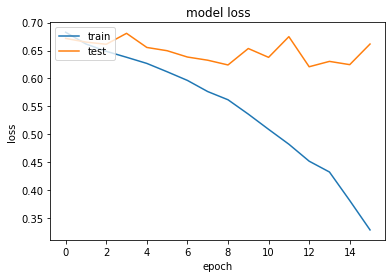

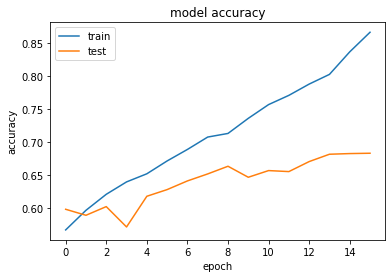

In [109]:
plot_train_history(hist_earlystop)

## Using L1 regularization

In [110]:
# copy-paste the baseline model, but add regularization terms to each layer
from keras import regularizers

reg_weight = 1.e-4

def get_l1_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_regularizer=regularizers.l1(reg_weight), input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu',
                     kernel_regularizer=regularizers.l1(reg_weight)))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l1(reg_weight)))
    model.add(Dense(1, activation='sigmoid',
                    kernel_regularizer=regularizers.l1(reg_weight)))
    
    return model

In [111]:
m_l1 = get_l1_model()

m_l1.compile(optimizers.SGD(lr=0.01, momentum=0.9, decay=1.e-6, nesterov=True),
               #optimizers.Adadelta(),
               "binary_crossentropy", 
               metrics=['accuracy'])

hist_l1 = m_l1.fit_generator(train_generator,
                             epochs=epochs,
                             steps_per_epoch=train_samples // batch_size,
                             validation_data=test_generator,
                             validation_steps=test_samples // batch_size)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


46/46 [==============================] - 1s 10ms/step - loss: 3.1467 - accuracy: 0.5358 - val_loss: 3.1159 - val_accuracy: 0.5489
Epoch 2/30
46/46 [==============================] - 0s 7ms/step - loss: 3.0618 - accuracy: 0.5923 - val_loss: 3.0235 - val_accuracy: 0.5973
Epoch 3/30
46/46 [==============================] - 0s 7ms/step - loss: 2.9773 - accuracy: 0.6138 - val_loss: 2.9473 - val_accuracy: 0.5912
Epoch 4/30
46/46 [==============================] - 0s 7ms/step - loss: 2.8989 - accuracy: 0.6093 - val_loss: 2.8751 - val_accuracy: 0.5993
Epoch 5/30
46/46 [==============================] - 0s 7ms/step - loss: 2.8257 - accuracy: 0.6328 - val_loss: 2.8026 - val_accuracy: 0.5988
Epoch 6/30
46/46 [==============================] - 0s 7ms/step - loss: 2.7485 - accuracy: 0.6454 - val_loss: 2.7377 - val_accuracy: 0.6048
Epoch 7/30
46/46 [==============================] - 0s 7ms/step - loss: 2.6737 - accuracy: 0.6413 - val_loss: 2.6662 - val_accuracy: 0.6114
Epoch 8/30
46/46 [============

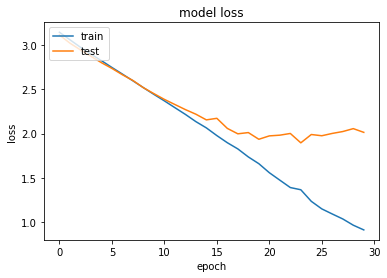

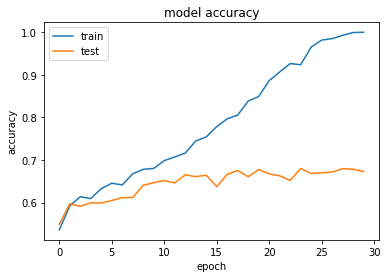

In [112]:
plot_train_history(hist_l1)

## Using L2 regularization

In [113]:
# copy-paste the baseline model, but add regularization terms to each layer
from keras import regularizers

reg_weight = 1.e-4

def get_l2_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_regularizer=regularizers.l2(reg_weight), input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu',
                     kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(reg_weight)))
    model.add(Dense(1, activation='sigmoid',
                    kernel_regularizer=regularizers.l2(reg_weight)))
    return model

In [114]:
m_l2 = get_l2_model()

m_l2.compile(optimizers.SGD(lr=0.01, momentum=0.9, decay=1.e-6, nesterov=True),
               #optimizers.Adadelta(),
               "binary_crossentropy", 
               metrics=['accuracy'])

hist_l2 = m_l2.fit_generator(train_generator,
                             epochs=epochs,
                             steps_per_epoch=train_samples // batch_size,
                             validation_data=test_generator,
                             validation_steps=test_samples // batch_size)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


46/46 [==============================] - 1s 10ms/step - loss: 0.7369 - accuracy: 0.5572 - val_loss: 0.7276 - val_accuracy: 0.5902
Epoch 2/30
46/46 [==============================] - 0s 7ms/step - loss: 0.7220 - accuracy: 0.5991 - val_loss: 0.7249 - val_accuracy: 0.5716
Epoch 3/30
46/46 [==============================] - 0s 7ms/step - loss: 0.7075 - accuracy: 0.6168 - val_loss: 0.7212 - val_accuracy: 0.5927
Epoch 4/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6999 - accuracy: 0.6250 - val_loss: 0.7174 - val_accuracy: 0.5998
Epoch 5/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6946 - accuracy: 0.6325 - val_loss: 0.7121 - val_accuracy: 0.6058
Epoch 6/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6864 - accuracy: 0.6451 - val_loss: 0.7056 - val_accuracy: 0.6159
Epoch 7/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6719 - accuracy: 0.6594 - val_loss: 0.6977 - val_accuracy: 0.6280
Epoch 8/30
46/46 [============

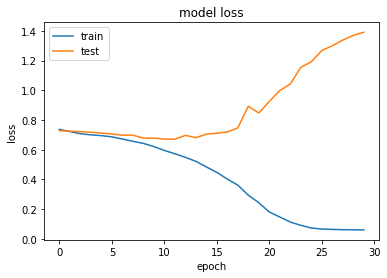

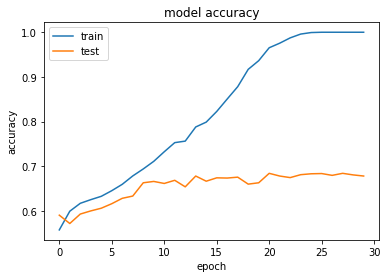

In [115]:
plot_train_history(hist_l2)

## Using L1 and L2 regularization

In [116]:
reg_weight = 1.e-4

def get_l1_l2_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight), input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu',
                     kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight)))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight)))
    model.add(Dense(1, activation='sigmoid',
                    kernel_regularizer=regularizers.l1_l2(reg_weight, reg_weight)))
    return model

In [117]:
m_l1l2 = get_l1_l2_model()

m_l1l2.compile(optimizers.SGD(lr=0.01, momentum=0.9, decay=1.e-6, nesterov=True),
               #optimizers.Adadelta(),
               "binary_crossentropy", 
               metrics=['accuracy'])

hist_l1l2 = m_l1l2.fit_generator(train_generator,
                                 epochs=epochs,
                                 steps_per_epoch=train_samples // batch_size,
                                 validation_data=test_generator,
                                 validation_steps=test_samples // batch_size)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


46/46 [==============================] - 1s 10ms/step - loss: 3.1994 - accuracy: 0.5507 - val_loss: 3.1514 - val_accuracy: 0.5912
Epoch 2/30
46/46 [==============================] - 0s 7ms/step - loss: 3.1062 - accuracy: 0.5940 - val_loss: 3.0652 - val_accuracy: 0.5948
Epoch 3/30
46/46 [==============================] - 0s 7ms/step - loss: 3.0179 - accuracy: 0.6213 - val_loss: 2.9874 - val_accuracy: 0.6053
Epoch 4/30
46/46 [==============================] - 0s 7ms/step - loss: 2.9334 - accuracy: 0.6250 - val_loss: 2.9108 - val_accuracy: 0.6064
Epoch 5/30
46/46 [==============================] - 0s 7ms/step - loss: 2.8501 - accuracy: 0.6356 - val_loss: 2.8470 - val_accuracy: 0.5817
Epoch 6/30
46/46 [==============================] - 0s 7ms/step - loss: 2.7718 - accuracy: 0.6403 - val_loss: 2.7693 - val_accuracy: 0.6048
Epoch 7/30
46/46 [==============================] - 0s 7ms/step - loss: 2.6911 - accuracy: 0.6540 - val_loss: 2.6861 - val_accuracy: 0.6260
Epoch 8/30
46/46 [============

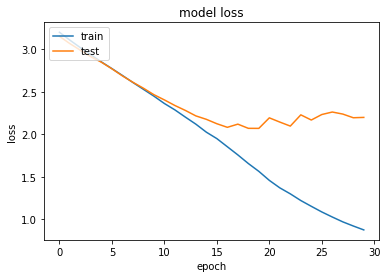

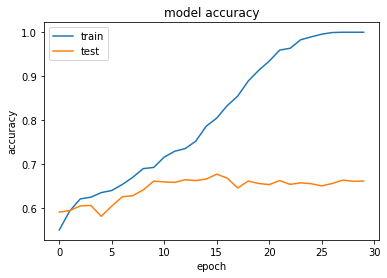

In [118]:
plot_train_history(hist_l1l2)

## Using dropout

In [119]:
from keras.layers import Dropout

def get_dropout_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [120]:
m_drop = get_dropout_model()

m_drop.compile(optimizers.SGD(lr=0.01, momentum=0.9, decay=1.e-6, nesterov=True),
               #optimizers.Adadelta(),
               "binary_crossentropy", 
               metrics=['accuracy'])

hist_drop = m_drop.fit_generator(train_generator,
                                 epochs=epochs,
                                 steps_per_epoch=train_samples // batch_size,
                                 validation_data=test_generator,
                                 validation_steps=test_samples // batch_size)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


46/46 [==============================] - 1s 9ms/step - loss: 0.6895 - accuracy: 0.5409 - val_loss: 0.6844 - val_accuracy: 0.5161
Epoch 2/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6826 - accuracy: 0.5548 - val_loss: 0.6747 - val_accuracy: 0.5922
Epoch 3/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6736 - accuracy: 0.5862 - val_loss: 0.6676 - val_accuracy: 0.5983
Epoch 4/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6643 - accuracy: 0.6093 - val_loss: 0.6629 - val_accuracy: 0.6149
Epoch 5/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6584 - accuracy: 0.6117 - val_loss: 0.6550 - val_accuracy: 0.6265
Epoch 6/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6467 - accuracy: 0.6267 - val_loss: 0.6468 - val_accuracy: 0.6235
Epoch 7/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6385 - accuracy: 0.6423 - val_loss: 0.6516 - val_accuracy: 0.6210
Epoch 8/30
46/46 [=============

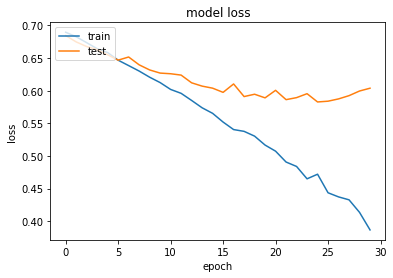

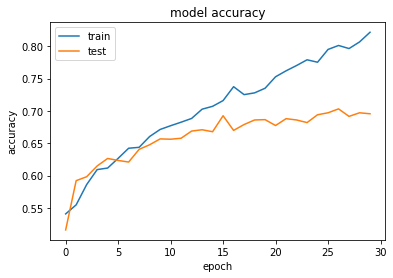

In [121]:
plot_train_history(hist_drop)

## Using batch normalization

In [122]:
from keras.layers import BatchNormalization

# TODO: batch norm after relu okay?
def get_batchnorm_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [123]:
m_bn = get_batchnorm_model()

m_bn.compile(optimizers.SGD(lr=0.01, momentum=0.9, decay=1.e-6, nesterov=True),
             "binary_crossentropy", 
             metrics=['accuracy'])

hist_bn = m_bn.fit_generator(train_generator,
                             epochs=epochs,
                             steps_per_epoch=train_samples // batch_size,
                             validation_data=test_generator,
                             validation_steps=test_samples // batch_size)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


46/46 [==============================] - 1s 11ms/step - loss: 0.7885 - accuracy: 0.5635 - val_loss: 0.7647 - val_accuracy: 0.5318
Epoch 2/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6344 - accuracy: 0.6376 - val_loss: 0.6915 - val_accuracy: 0.5766
Epoch 3/30
46/46 [==============================] - 0s 7ms/step - loss: 0.6068 - accuracy: 0.6727 - val_loss: 0.6827 - val_accuracy: 0.5716
Epoch 4/30
46/46 [==============================] - 0s 7ms/step - loss: 0.5808 - accuracy: 0.6935 - val_loss: 0.6606 - val_accuracy: 0.6003
Epoch 5/30
46/46 [==============================] - 0s 7ms/step - loss: 0.5462 - accuracy: 0.7228 - val_loss: 0.6922 - val_accuracy: 0.5786
Epoch 6/30
46/46 [==============================] - 0s 8ms/step - loss: 0.5171 - accuracy: 0.7544 - val_loss: 0.8764 - val_accuracy: 0.5348
Epoch 7/30
46/46 [==============================] - 0s 7ms/step - loss: 0.4810 - accuracy: 0.7752 - val_loss: 1.3195 - val_accuracy: 0.4940
Epoch 8/30
46/46 [============

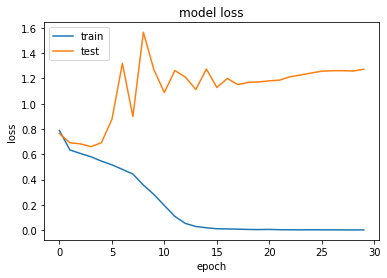

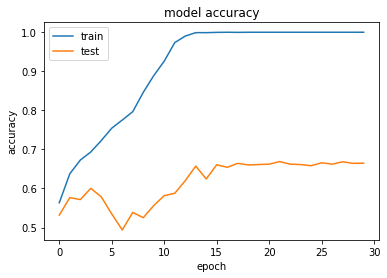

In [124]:
plot_train_history(hist_bn)

## Using data augmentation

In [125]:
# now we need to set up a different input pipeline that does the augmentation for us
train_datagen_aug = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator_aug = train_datagen_aug.flow(x_train_small, y_train_small,
                                             batch_size=batch_size,
                                             shuffle=True)

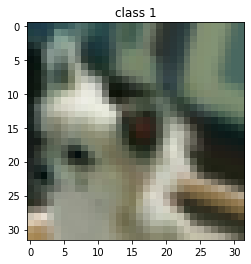

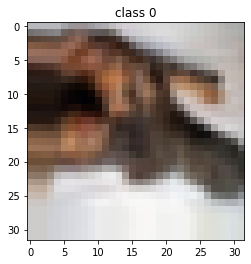

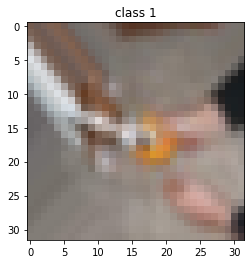

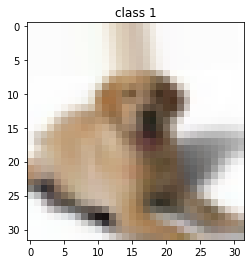

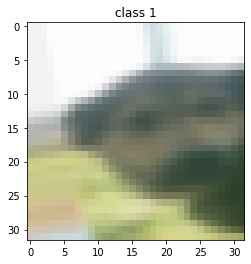

In [126]:
# plot some augmented images
img_batch, label_batch = train_generator_aug.next()
for i in range(5):
    plt.imshow(img_batch[i])
    plt.title("class " + str(label_batch[i]))
    plt.show()


In [127]:
# during validation we do NOT augment the images of course
test_datagen_aug = ImageDataGenerator(
    rescale=1. / 255,
)
test_generator_aug = test_datagen_aug.flow(x_te, y_te,
                                   batch_size=batch_size,
                                   shuffle=True)

In [128]:
m_base = get_baseline_model_cnn()

m_base.compile(optimizers.SGD(lr=0.01, momentum=0.9, decay=1.e-6, nesterov=True),
               "binary_crossentropy", 
               metrics=['accuracy'])


hist_aug = m_base.fit_generator(train_generator_aug,
                                epochs=epochs,
                                steps_per_epoch=train_samples // batch_size,
                                validation_data=test_generator_aug,
                                validation_steps=test_samples // batch_size)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


46/46 [==============================] - 2s 34ms/step - loss: 0.6940 - accuracy: 0.5058 - val_loss: 0.6852 - val_accuracy: 0.5544
Epoch 2/30
46/46 [==============================] - 1s 31ms/step - loss: 0.6886 - accuracy: 0.5381 - val_loss: 0.6784 - val_accuracy: 0.5650
Epoch 3/30
46/46 [==============================] - 1s 31ms/step - loss: 0.6851 - accuracy: 0.5582 - val_loss: 0.6748 - val_accuracy: 0.5590
Epoch 4/30
46/46 [==============================] - 1s 31ms/step - loss: 0.6838 - accuracy: 0.5623 - val_loss: 0.6697 - val_accuracy: 0.5822
Epoch 5/30
46/46 [==============================] - 1s 31ms/step - loss: 0.6801 - accuracy: 0.5678 - val_loss: 0.6715 - val_accuracy: 0.5953
Epoch 6/30
46/46 [==============================] - 1s 31ms/step - loss: 0.6780 - accuracy: 0.5848 - val_loss: 0.6674 - val_accuracy: 0.5912
Epoch 7/30
46/46 [==============================] - 1s 30ms/step - loss: 0.6784 - accuracy: 0.5736 - val_loss: 0.6668 - val_accuracy: 0.5897
Epoch 8/30
46/46 [======

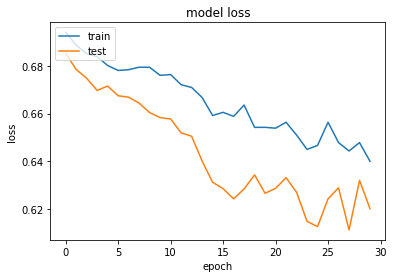

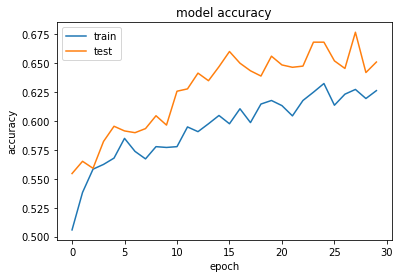

In [129]:
plot_train_history(hist_aug)

## Putting the things that worked together: EarlyStopping, Dropout, BatchNorm and Data augmentation

In [130]:
def get_regularized_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.15))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [131]:
m_reg = get_regularized_model()

m_reg.compile(optimizers.SGD(lr=0.01, momentum=0.9, decay=1.e-6, nesterov=True),
                "binary_crossentropy", 
                metrics=['accuracy'])

hist_reg = m_reg.fit_generator(train_generator_aug,
                             epochs=epochs,
                             steps_per_epoch=train_samples // batch_size,
                             validation_data=test_generator_aug,
                             validation_steps=test_samples // batch_size,
                              callbacks=[
                                  EarlyStopping(monitor='val_loss', min_delta=0.01, patience=25, verbose=1)])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


46/46 [==============================] - 2s 34ms/step - loss: 0.6920 - accuracy: 0.5126 - val_loss: 0.6835 - val_accuracy: 0.5711
Epoch 2/30
46/46 [==============================] - 1s 31ms/step - loss: 0.6850 - accuracy: 0.5555 - val_loss: 0.6790 - val_accuracy: 0.5539
Epoch 3/30
46/46 [==============================] - 1s 31ms/step - loss: 0.6862 - accuracy: 0.5572 - val_loss: 0.6755 - val_accuracy: 0.5862
Epoch 4/30
46/46 [==============================] - 1s 31ms/step - loss: 0.6831 - accuracy: 0.5610 - val_loss: 0.6704 - val_accuracy: 0.5837
Epoch 5/30
46/46 [==============================] - 1s 31ms/step - loss: 0.6755 - accuracy: 0.5736 - val_loss: 0.6672 - val_accuracy: 0.5907
Epoch 6/30
46/46 [==============================] - 1s 31ms/step - loss: 0.6788 - accuracy: 0.5688 - val_loss: 0.6675 - val_accuracy: 0.5902
Epoch 7/30
46/46 [==============================] - 1s 31ms/step - loss: 0.6795 - accuracy: 0.5751 - val_loss: 0.6657 - val_accuracy: 0.5827
Epoch 8/30
46/46 [======

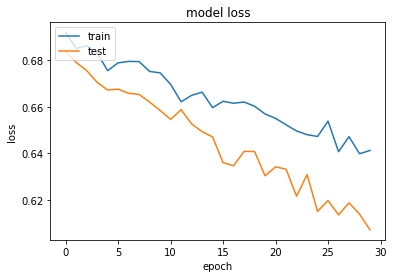

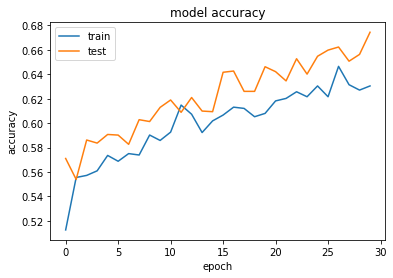

In [132]:
plot_train_history(hist_reg)